**follow: https://github.com/zjysteven/VLM-Visualizer.git**

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
import json
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import argparse 
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import matplotlib.pyplot as plt

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        "pretrained/Qwen2.5-VL-3B-Instruct",
        torch_dtype=torch.bfloat16,
        # attn_implementation="flash_attention_2",
        attn_implementation="eager",
        device_map="auto",
    )

# default processor
processor = AutoProcessor.from_pretrained("pretrained/Qwen2.5-VL-3B-Instruct")

/data_all/cjj_node/vit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [15]:
img_path = "demo_images/catdog.png"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img_path,
                "resized_height": 224,
                "resized_width": 224, # 至少要(560 / 28) ** 2 = 400个token
            },
            # {"type": "text", "text": "Find the dog in figure"},
            {"type": "text", "text": "Describle this photo in detail"}
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, 
    tokenize=False, 
    add_generation_prompt=True,
    enable_thinking = True, # 设置思考
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

# 添加可选参数，获取返回的attentions
inputs['output_attentions'] = True
for keys in inputs.keys():
    print(keys)
inputs = inputs.to(model.device)

input_ids
attention_mask
pixel_values
image_grid_thw
output_attentions


In [18]:
input_ids = inputs['input_ids']
print(input_ids)
print(input_ids.shape)
print("\n")
print(text)

tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653,  62664,
            891,    419,   6548,    304,   7716, 151645,    198, 151644,  77091,
            198]], device='cuda:0')
torch.Size([1, 91])


<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Describle this

**提取注意力**

In [16]:
outputs,vit_attns = model(**inputs)
vl_attns = outputs.attentions

In [ ]:
logits = outputs.logits
print(logits.shape)

# logits 是输出的预测分数，其sequence_length与输入的sequence_length相同，但是偏移一位，这是典型的预测序列.

torch.Size([1, 91, 151936])


: 

### **language-model部分**

**构造input token的注意力矩阵**

### **visual-model部分**

**构造image patch token注意力矩阵**

In [5]:
print(len(vit_attns),vit_attns[0].shape)

32 torch.Size([1, 16, 256, 256])


In [6]:
def aggregate_vit_attention(attn):
    """attn is visual attentions of visual model"""
    avged = []
    for i, layer in enumerate(attn):
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[:, :].cpu() # Only image token
        avged.append(vec / vec.sum(-1, keepdim=True))
    return torch.stack(avged).mean(dim=0)

In [7]:
vit_attn_matrix = aggregate_vit_attention(vit_attns)
vit_attn_matrix = vit_attn_matrix.to(torch.float32)
print(vit_attn_matrix.shape)
print(vit_attn_matrix.dtype)

torch.Size([256, 256])
torch.float32


**展示注意力矩阵**

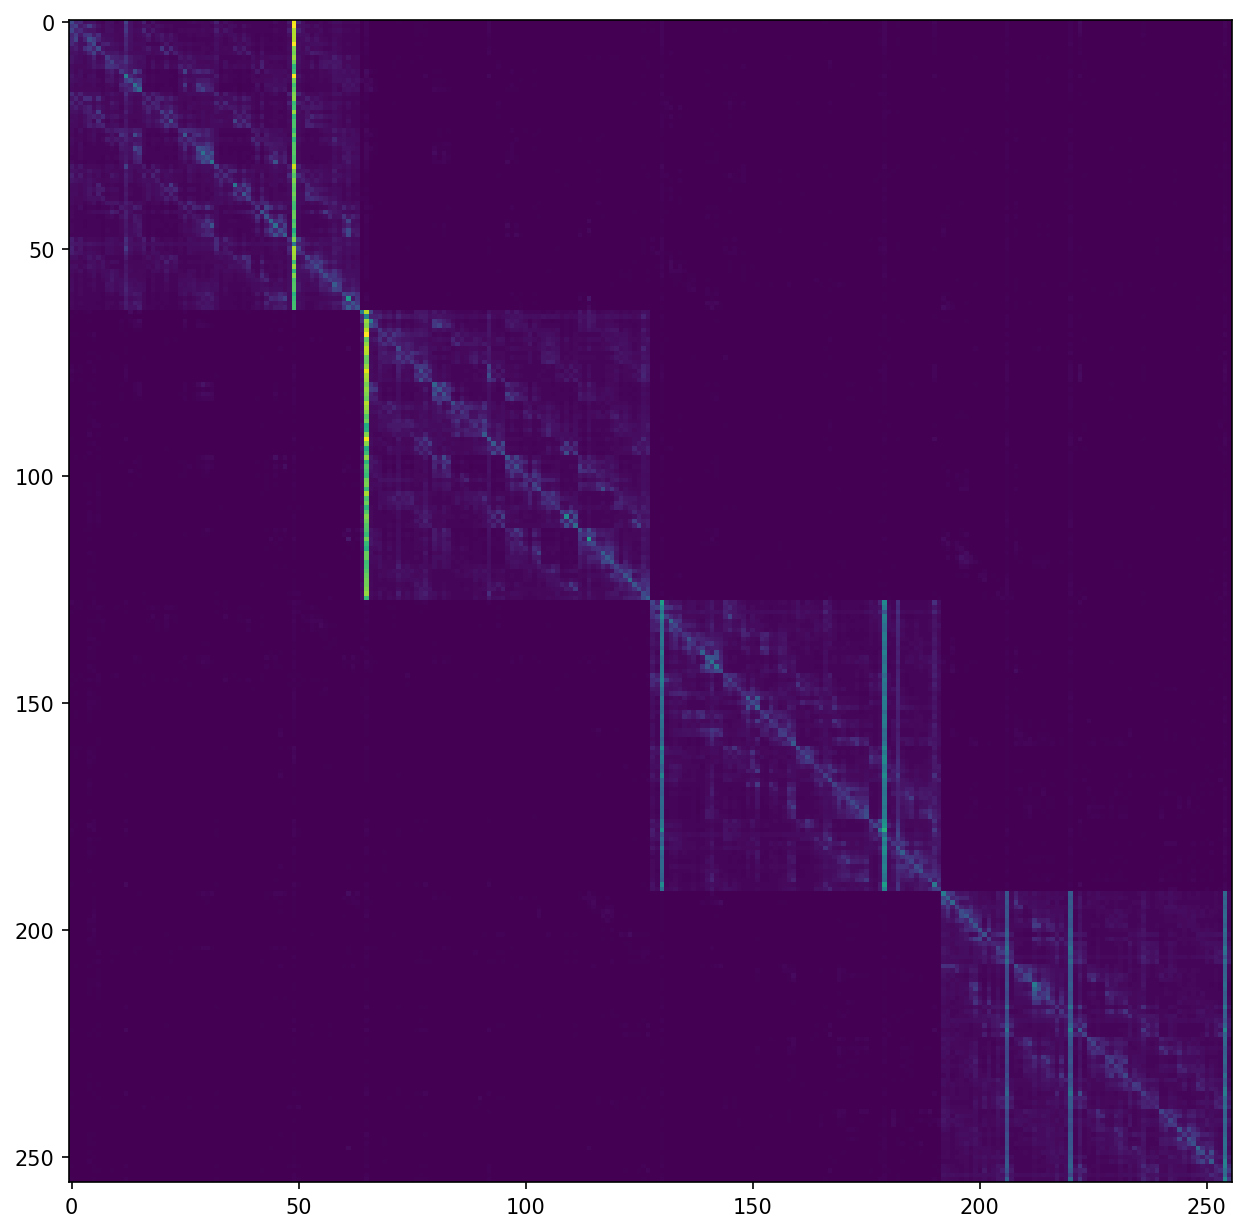

In [8]:
gamma_factor = 1
enhanced_attn_m = np.power(vit_attn_matrix.detach().numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

### **将visual注意力应用到input tokens上**

**未完成!!!**

In [10]:
image = Image.open(img_path)
image_size = image.size
print(image_size)

(224, 224)


In [ ]:
patch_size = 14
grid_size =patch_size * patch_size

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0), 
        size=image.size, 
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");